# BRW Estimation

Replication code of the BRW shock by Bu, Wu, and Rogers (2021).

In [41]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS

maturity = 2
year = 2020
month = 12
monthname = "Dec"
MAR2020 = 0

## 1. Calculating the difference of the 2-year Treasury series (DGS2)

Load the data and rename columns

In [42]:
data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\DGS2.xls")
data.rename(columns={"observation_date": "date"}, inplace=True)
data.sort_values(by='date', inplace=True)
data.replace(0, method='ffill', inplace=True)

Convert date to datetime format and create additional date-related columns

In [43]:
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["mdate"] = data["date"].dt.to_period("M")

Filter data for the specified period (up to September 2019 - Cut-off date used for the estimation in the research paper.)

In [44]:
data = data[data["mdate"] <= pd.Period("2019-09")]
data = data[data["mdate"] >= pd.Period("1994-01")]

Calculate the difference of the series (dgs_d)

In [45]:
data["dgs_d"] = data["DGS" + str(maturity)] - data["DGS" + str(maturity)].shift(1)

Set "mdate" as the index and convert it to a time series

In [46]:
data.set_index("mdate", inplace=True)
data.index = pd.to_datetime(data.index.to_timestamp())

Drop unnecessary columns

In [47]:
data.drop(columns=["year", "month", "day"], inplace=True)
data.head()

,date,DGS2,dgs_d
mdate,,,
2000-04-01,2000-04-04,18.4837,NaN
2000-04-01,2000-04-05,18.7000,0.2163
2000-04-01,2000-04-06,18.8277,0.1277
2000-04-01,2000-04-07,18.6444,-0.1833
2000-04-01,2000-04-08,18.6444,0.0000


Save the resulting DataFrame to a new file

In [48]:
data.to_pickle("temp.pkl")

## 2. Adding COPOM dates

Load the COPOM dates from the Excel file

In [49]:
copom_dates = pd.read_excel("C:/Users/Alysson/Documents/GitHub/Monetary-Shocks/Brasil/BRW/COPOMdate.xlsx")
copom_dates.rename(columns={"date": "COPOM_date"}, inplace=True)

Convert date to datetime format and create additional date-related columns

In [50]:
copom_dates["COPOM_date"] = pd.to_datetime(copom_dates["COPOM_date"])
copom_dates["year"] = copom_dates["COPOM_date"].dt.year
copom_dates["month"] = copom_dates["COPOM_date"].dt.month
copom_dates["day"] = copom_dates["COPOM_date"].dt.day
copom_dates["mdate"] = copom_dates["COPOM_date"].dt.to_period("M")

MAR2020 = 0

if MAR2020 == 0:
    copom_dates = copom_dates[~((copom_dates["year"] == 2020) & (copom_dates["month"] == 3) & (copom_dates["day"] == 15))]


Drop unnecessary columns

In [51]:
copom_dates.drop(columns=["year", "month", "day"], inplace=True)

Load the previous DataFrame "temp.dta" 

In [52]:
temp_data = pd.read_pickle("temp.pkl")

Merge the two DataFrames on the 'date' column

In [53]:
merged_data = pd.merge(temp_data, copom_dates, how="inner", left_on="date", right_on="COPOM_date")

Drop rows where 'q' is missing (denoted as NaN)

In [54]:
merged_data = merged_data.dropna(subset=["q"])

Replace missing values (NaN) in 'q' with 0

In [55]:
merged_data["q"].fillna(0, inplace=True)
merged_data.head()

,date,DGS2,dgs_d,COPOM_date,q,mdate
0,2000-04-19,19.6318,-0.0201,2000-04-19,1,2000-04
1,2000-05-02,20.6528,0.4277,2000-05-02,0,2000-05
2,2000-05-24,22.0304,-0.4711,2000-05-24,1,2000-05
3,2000-06-02,20.2087,-0.4626,2000-06-02,0,2000-06
4,2000-06-20,19.3421,-0.0962,2000-06-20,1,2000-06


Save the merged DataFrame to a new file

In [56]:
merged_data.to_pickle("temp.pkl")

## 3. Estimation

Load the data from "svensson_br.xlsx" 

In [57]:
yield_data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\svensson_br.xlsx")

Convert 'date' column to datetime format and keeping only necessary columns

In [58]:
yield_data['date'] = pd.to_datetime(yield_data['Date'], format='%Y-%m-%d')
yield_data.sort_values(by='date', inplace=True)
yield_data.loc[:, 'SVENY01':'SVENY30'] = yield_data.loc[:, 'SVENY01':'SVENY30'].fillna(method='ffill')

In [59]:
yield_data['year'] = yield_data['date'].dt.year
yield_data['month'] = yield_data['date'].dt.month
yield_data['day'] = yield_data['date'].dt.day
yield_data['date'] = pd.to_datetime(yield_data[['year', 'month', 'day']])
yield_data['mdate'] = yield_data['date'].dt.to_period('M')
yield_data = yield_data[['date', 'mdate'] + [col for col in yield_data.columns if col.startswith('SVENY')]]
yield_data = yield_data[yield_data['mdate'] >= pd.Period('1994-01')]

In [60]:
yield_data

,date,mdate,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,...,SVENY21,SVENY22,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30
0,2006-01-02,2006-01,16.603599,16.069818,15.813602,15.678468,15.596889,15.542471,15.503599,15.474444,...,15.348109,15.344575,15.341349,15.338391,15.335670,15.333158,15.330832,15.328673,15.326662,15.324786
1,2006-01-03,2006-01,16.594441,16.064808,15.800027,15.659489,15.574586,15.517946,15.477487,15.447142,...,15.315649,15.311971,15.308612,15.305534,15.302702,15.300088,15.297667,15.295419,15.293326,15.291373
2,2006-01-04,2006-01,16.567391,15.906773,15.597463,15.460412,15.396983,15.364394,15.345285,15.332609,...,15.283329,15.281973,15.280736,15.279601,15.278557,15.277594,15.276701,15.275873,15.275102,15.274382
3,2006-01-05,2006-01,16.564073,15.900342,15.579618,15.436914,15.374310,15.346010,15.332288,15.324890,...,15.304758,15.304254,15.303794,15.303372,15.302984,15.302626,15.302294,15.301986,15.301699,15.301432
4,2006-01-06,2006-01,16.537489,15.886892,15.571989,15.437172,15.385606,15.369317,15.366877,15.369324,...,15.398403,15.399311,15.400141,15.400901,15.401600,15.402245,15.402843,15.403398,15.403915,15.404397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4407,2023-07-24,2023-07,11.422015,10.375426,10.287456,10.426576,10.579465,10.704416,10.800943,10.875586,...,11.204547,11.213765,11.222181,11.229896,11.236994,11.243545,11.249612,11.255245,11.260489,11.265384
4408,2023-07-25,2023-07,11.328594,10.296519,10.229356,10.384433,10.548691,10.681778,10.784285,10.863463,...,11.212188,11.221959,11.230880,11.239058,11.246581,11.253526,11.259957,11.265928,11.271487,11.276676
4409,2023-07-26,2023-07,11.252950,10.250362,10.203129,10.368377,10.538217,10.674738,10.779577,10.860458,...,11.216422,11.226395,11.235501,11.243848,11.251527,11.258615,11.265179,11.271273,11.276947,11.282243
4410,2023-07-27,2023-07,11.263837,10.293272,10.273538,10.459411,10.644010,10.791139,10.903794,10.990610,...,11.372468,11.383165,11.392933,11.401886,11.410123,11.417727,11.424767,11.431305,11.437391,11.443072


Create a list for all maturities of the treasuries

Calculate differences for each maturity

In [61]:
list_maturities = [str(i).zfill(2) for i in range(1, 31)]

for num in list_maturities:
    col_name = f'SVENY{num}'
    yield_data[f'{col_name}_d'] = yield_data[col_name].diff()
selected_columns = yield_data.iloc[:, -30:]

Create aligned_dgs_d column

In [62]:
data_complete = merged_data.merge(yield_data, on=['date','mdate'], how='inner')
data_complete.head()

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,SVENY21_d,SVENY22_d,SVENY23_d,SVENY24_d,SVENY25_d,SVENY26_d,SVENY27_d,SVENY28_d,SVENY29_d,SVENY30_d
0,2006-01-18,16.1660,-0.0851,2006-01-18,1,2006-01,16.168296,15.574431,15.318876,15.208869,...,0.019636,0.018121,0.016738,0.015471,0.014305,0.013229,0.012232,0.011307,0.010445,0.009641
1,2006-01-27,16.0248,-0.0050,2006-01-27,0,2006-01,15.989710,15.491880,15.263064,15.143962,...,-0.068936,-0.069019,-0.069095,-0.069164,-0.069228,-0.069287,-0.069342,-0.069393,-0.069440,-0.069484
2,2006-03-08,15.2753,0.1228,2006-03-08,1,2006-03,15.303771,14.930037,14.711954,14.572016,...,0.166905,0.166399,0.165938,0.165514,0.165125,0.164765,0.164433,0.164123,0.163836,0.163567
3,2006-03-17,14.9718,0.0529,2006-03-17,0,2006-03,14.953553,14.517989,14.325711,14.210984,...,0.020568,0.020444,0.020330,0.020226,0.020131,0.020043,0.019961,0.019885,0.019814,0.019748
4,2006-04-19,14.6501,-0.0194,2006-04-19,1,2006-04,14.639425,14.616213,14.723955,14.805587,...,0.799602,0.821436,0.841429,0.859793,0.876714,0.892348,0.906836,0.920295,0.932831,0.944534


### Step 1 - 2SLS

In [63]:
### Creating IV

mask_q0 = data_complete["q"] == 0
mask_q1 = data_complete["q"] == 1
data_complete["const"] = 1
data_complete["iv"] = data_complete[mask_q1]["dgs_d"]
data_complete.loc[mask_q0, "iv"] = -1 * data_complete.loc[mask_q0, "dgs_d"]

In [64]:
subset_data = data_complete

# Especifique o nome do arquivo Excel de saída
output_file = "data_subset.xlsx"

# Salve o DataFrame no arquivo Excel
subset_data.to_excel(output_file, index=False)

In [65]:
for num in list_maturities:
    col_name = f'SVENY{num}_d'
    model = IV2SLS(dependent=data_complete[col_name], endog=data_complete["dgs_d"], exog=data_complete[["const"]], instruments=data_complete["iv"])
    results = model.fit()
    data_complete[f"beta_hat{num}"]=results.params["dgs_d"]
    print(results)
data_complete.head()

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                     -0.3160
Estimator:                    IV-2SLS   Adj. R-squared:                -0.3221
No. Observations:                 220   F-statistic:                    2.7585
Date:                Wed, Sep 06 2023   P-value (F-stat)                0.0967
Time:                        09:20:30   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0026     0.0064    -0.4134     0.6793     -0.0151      0.0099
dgs_d          0.6152     0.3704     1.6609     0.09

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY14_d   R-squared:                     -0.1340
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1392
No. Observations:                 220   F-statistic:                    3.3391
Date:                Wed, Sep 06 2023   P-value (F-stat)                0.0677
Time:                        09:20:30   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0055     0.0116    -0.4753     0.6346     -0.0282      0.0172
dgs_d          0.7831     0.4286     1.8273     0.06

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY26_d   R-squared:                     -0.1177
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1228
No. Observations:                 220   F-statistic:                    3.3876
Date:                Wed, Sep 06 2023   P-value (F-stat)                0.0657
Time:                        09:20:30   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0006     0.0141     0.0426     0.9660     -0.0271      0.0283
dgs_d          0.8860     0.4814     1.8406     0.06

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,beta_hat21,beta_hat22,beta_hat23,beta_hat24,beta_hat25,beta_hat26,beta_hat27,beta_hat28,beta_hat29,beta_hat30
0,2006-01-18,16.1660,-0.0851,2006-01-18,1,2006-01,16.168296,15.574431,15.318876,15.208869,...,0.853548,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895
1,2006-01-27,16.0248,-0.0050,2006-01-27,0,2006-01,15.989710,15.491880,15.263064,15.143962,...,0.853548,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895
2,2006-03-08,15.2753,0.1228,2006-03-08,1,2006-03,15.303771,14.930037,14.711954,14.572016,...,0.853548,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895
3,2006-03-17,14.9718,0.0529,2006-03-17,0,2006-03,14.953553,14.517989,14.325711,14.210984,...,0.853548,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895
4,2006-04-19,14.6501,-0.0194,2006-04-19,1,2006-04,14.639425,14.616213,14.723955,14.805587,...,0.853548,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895


### Step 2 - Fama and MacBeth

In [66]:
data_complete = data_complete.loc[~mask_q0]
maxt = len(data_complete)

aligned_dgs_d = []
for num in range(maxt):
    sveny_values = data_complete.iloc[num, data_complete.columns.get_loc("SVENY01_d"):data_complete.columns.get_loc("SVENY30_d") + 1].values.astype(float)
    beta_values = data_complete.iloc[num, data_complete.columns.get_loc("beta_hat01"):data_complete.columns.get_loc("beta_hat30") + 1].values.astype(float)

    # Adicionando uma constante à matriz independente (para o termo constante na regressão)
    X = sm.add_constant(beta_values)

    # Realizando a regressão usando o OLS do StatsModels
    model = sm.OLS(sveny_values, X)
    results = model.fit()

    # Imprimindo os coeficientes beta estimados
    aligned_dgs_d.append(results.params[1:])

data_complete["new_shock"]=aligned_dgs_d
data_complete["new_shock"] = data_complete["new_shock"].apply(lambda x: x[0])

C:\Users\Alysson\AppData\Local\Temp\ipykernel_23192\953814133.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_complete["new_shock"]=aligned_dgs_d
C:\Users\Alysson\AppData\Local\Temp\ipykernel_23192\953814133.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_complete["new_shock"] = data_complete["new_shock"].apply(lambda x: x[0])


In [67]:
data_complete

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,beta_hat22,beta_hat23,beta_hat24,beta_hat25,beta_hat26,beta_hat27,beta_hat28,beta_hat29,beta_hat30,new_shock
0,2006-01-18,16.1660,-0.0851,2006-01-18,1,2006-01,16.168296,15.574431,15.318876,15.208869,...,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,-0.232135
2,2006-03-08,15.2753,0.1228,2006-03-08,1,2006-03,15.303771,14.930037,14.711954,14.572016,...,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,0.060301
4,2006-04-19,14.6501,-0.0194,2006-04-19,1,2006-04,14.639425,14.616213,14.723955,14.805587,...,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,3.873276
6,2006-05-31,15.5581,0.2824,2006-05-31,1,2006-05,15.650954,16.233859,16.492478,16.647477,...,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,0.051984
8,2006-07-19,14.5308,-0.1601,2006-07-19,1,2006-07,14.561411,14.930508,15.213151,15.430707,...,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,-0.294558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,2019-03-20,6.3788,-0.0386,2019-03-20,1,2019-03,6.378840,7.005443,7.582564,8.000544,...,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,0.150284
212,2019-05-08,6.5281,-0.0257,2019-05-08,1,2019-05,6.528161,7.252637,7.836791,8.229570,...,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,0.053201
214,2019-06-19,5.9381,0.0229,2019-06-19,1,2019-06,5.938179,6.281809,6.727705,7.098164,...,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,-0.102986
216,2019-07-31,5.4398,0.0731,2019-07-31,1,2019-07,5.439882,5.766496,6.224152,6.596508,...,0.861047,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,-0.030570


### Renormalization

In [68]:
renormalization = sm.OLS(data_complete["dgs_d"], data_complete["new_shock"])
results_renormalization = renormalization.fit()
beta_estimado = results_renormalization.params["new_shock"]
data_complete["BRW_daily"]=data_complete["new_shock"]*beta_estimado 
#print(results_renormalization.summary())


C:\Users\Alysson\AppData\Local\Temp\ipykernel_23192\2463519393.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_complete["BRW_daily"]=data_complete["new_shock"]*beta_estimado


In [69]:
BRW_regression = sm.OLS(data_complete["dgs_d"], data_complete["BRW_daily"])
results_BRW_regression = BRW_regression.fit()
print(results_BRW_regression.summary())

                                 OLS Regression Results                                
Dep. Variable:                  dgs_d   R-squared (uncentered):                   0.018
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              2.000
Date:                Wed, 06 Sep 2023   Prob (F-statistic):                       0.160
Time:                        09:21:00   Log-Likelihood:                          34.849
No. Observations:                 110   AIC:                                     -67.70
Df Residuals:                     109   BIC:                                     -65.00
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

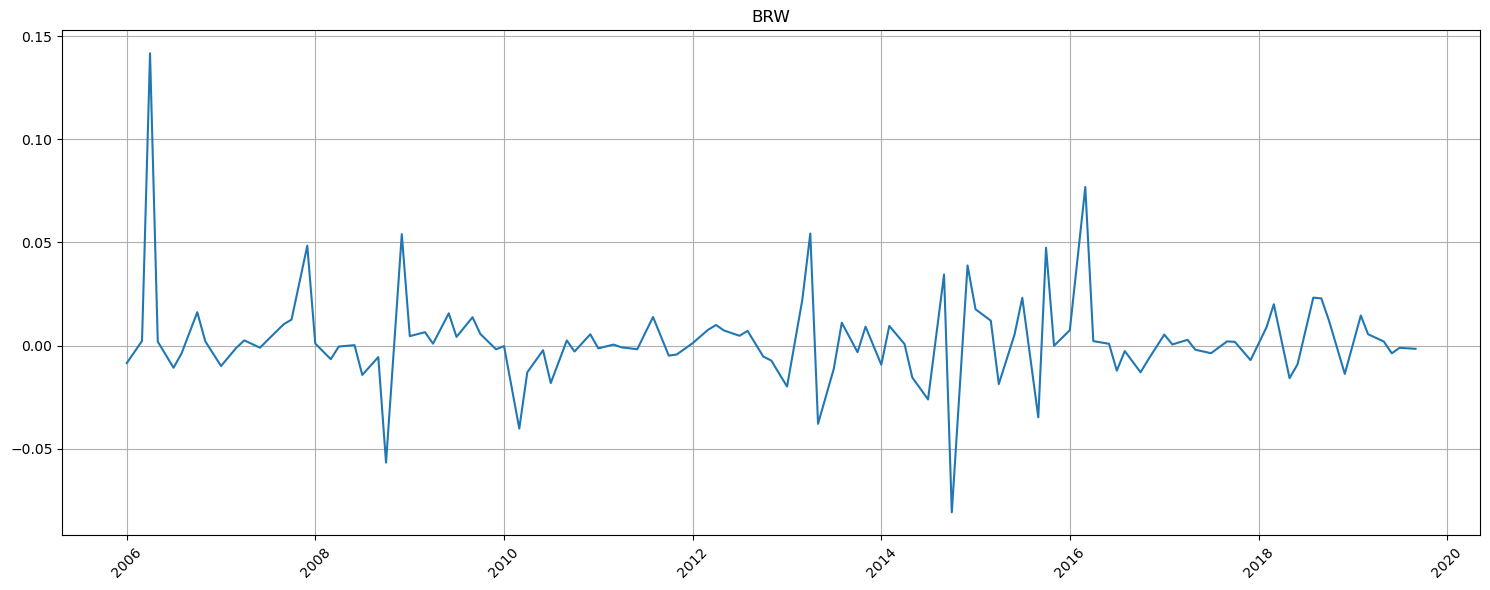

In [76]:
# Converter valores do tipo Period para datetime
mdate_values = data_complete["mdate"].dt.to_timestamp()
new_shock_values = data_complete["BRW_daily"]

# Criar um gráfico de linha
plt.figure(figsize=(15, 6))
plt.plot(mdate_values, new_shock_values)
plt.title("BRW")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
subset_data = data_complete

# Especifique o nome do arquivo Excel de saída
output_file = "data_subset.xlsx"

# Salve o DataFrame no arquivo Excel
subset_data.to_excel(output_file, index=False)

In [74]:
# Definir a data de início e a data de término
start_date = pd.to_datetime("1994-01-01")
end_date = pd.to_datetime("2019-09-01")  # Especifique a data de término desejada

# Criar um intervalo de datas mensais até a data de término
date_range = pd.date_range(start=start_date, end=end_date, freq="M")

# Criar um DataFrame com a coluna de datas
data_monthly = pd.DataFrame({'mdate': date_range})

# Formatar as datas no estilo "1994-02"
data_monthly['mdate'] = data_monthly['mdate'].dt.strftime('%Y-%m')

# Imprimir as primeiras linhas do DataFrame
print(data_monthly.head())


     mdate
0  1994-01
1  1994-02
2  1994-03
3  1994-04
4  1994-05


In [75]:
data_complete

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,beta_hat23,beta_hat24,beta_hat25,beta_hat26,beta_hat27,beta_hat28,beta_hat29,beta_hat30,new_shock,BRW_daily
0,2006-01-18,16.1660,-0.0851,2006-01-18,1,2006-01,16.168296,15.574431,15.318876,15.208869,...,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,-0.232135,-0.008489
2,2006-03-08,15.2753,0.1228,2006-03-08,1,2006-03,15.303771,14.930037,14.711954,14.572016,...,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,0.060301,0.002205
4,2006-04-19,14.6501,-0.0194,2006-04-19,1,2006-04,14.639425,14.616213,14.723955,14.805587,...,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,3.873276,0.141638
6,2006-05-31,15.5581,0.2824,2006-05-31,1,2006-05,15.650954,16.233859,16.492478,16.647477,...,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,0.051984,0.001901
8,2006-07-19,14.5308,-0.1601,2006-07-19,1,2006-07,14.561411,14.930508,15.213151,15.430707,...,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,-0.294558,-0.010771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,2019-03-20,6.3788,-0.0386,2019-03-20,1,2019-03,6.378840,7.005443,7.582564,8.000544,...,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,0.150284,0.005496
212,2019-05-08,6.5281,-0.0257,2019-05-08,1,2019-05,6.528161,7.252637,7.836791,8.229570,...,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,0.053201,0.001945
214,2019-06-19,5.9381,0.0229,2019-06-19,1,2019-06,5.938179,6.281809,6.727705,7.098164,...,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,-0.102986,-0.003766
216,2019-07-31,5.4398,0.0731,2019-07-31,1,2019-07,5.439882,5.766496,6.224152,6.596508,...,0.868,0.874454,0.880452,0.886034,0.891237,0.896095,0.900639,0.904895,-0.030570,-0.001118
